In [84]:
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, default_collate
from operator import itemgetter
import torch.nn as nn
import torch.nn.functional as F

In [85]:
name = 'fashion_mnist'
x,y = 'image','label'
dsd = load_dataset(name)

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [86]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [87]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [88]:
@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(ele)) for ele in b[x]]

In [89]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, **kwargs)
    )

def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f
    
class DataLoaders:
    def __init__(self, *ds):
        self.train,self.valid = ds[:2]
        
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))     

In [90]:
tds = dsd.with_transform(transformi)

In [91]:
bs = 1024

In [92]:
dls = DataLoaders.from_dd(tds, batch_size=bs)

In [93]:
t = iter(dls.train)

In [94]:
xb,yb = next(t)

In [95]:
xb.shape, yb.shape

(torch.Size([1024, 784]), torch.Size([1024]))

(<matplotlib.image.AxesImage at 0x17b2ab510>, 'Sandal')

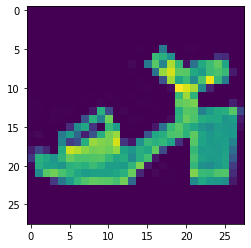

In [96]:
plt.imshow(xb[1].view(28, 28)), dsd['train'].features['label'].int2str(yb[1].item())

In [97]:
import fastcore.all as fc
import torch.optim as optim

In [98]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [99]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        fc.store_attr()
    
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_batch(self):
        self.xb,self.yb = self.batch
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
        
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(self.n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [100]:
n,nh=28*28, 50
model = nn.Sequential(*[nn.Linear(n,nh), nn.ReLU(nh), nn.Linear(nh,10)])

In [101]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)

In [102]:
learn.fit(1)

0 True 1.1432341145833333 0.6161333333333333
0 False 1.08700625 0.6319428571428571


In [103]:
from operator import attrgetter

In [104]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [105]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass


class Callback: order = 0

class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')


In [106]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [111]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()
            
    def one_batch(self):
        self.xb,self.yb = self.batch
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
    
    def one_epoch(self, train):
        self.model.training = train
        dl = dls.train if train else dls.valid
        try:
            self.callback('before_epoch')
            for self.num,self.batch in enumerate(dl): 
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException:
                    pass
            self.callback('after_epoch')
        
        except CancelEpochException:
            pass
   
    def fit(self, n_epochs):
        self.model.to(def_device)
        self.n_epochs = n_epochs
        self.accs,self.losses,self.ns = [],[],[]
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in range(self.n_epochs): 
                self.one_epoch(True)
                with torch.no_grad(): self.one_epoch(False) 
            self.callback('after_fit')
        except CancelFitException:
            pass
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [112]:
n,nh=28*28, 50
model = nn.Sequential(*[nn.Linear(n,nh), nn.ReLU(nh), nn.Linear(nh,10)])

In [113]:
learn = Learner(model, dls, cbs=[CompletionCB()], loss_func=F.cross_entropy, lr=0.2)

In [114]:
learn.fit(1)

Completed 64 batches


In [115]:
n,nh=28*28, 50
def get_model(): return nn.Sequential(*[nn.Linear(n,nh), nn.ReLU(nh), nn.Linear(nh,10)])

In [117]:
learn = Learner(get_model(), dls, cbs=[CompletionCB()], loss_func=F.cross_entropy, lr=0.2)

In [118]:
learn.fit(1)

Completed 64 batches


In [119]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [122]:
learn = Learner(get_model(), dls, cbs=[SingleBatchCB(), CompletionCB()], loss_func=F.cross_entropy, lr=0.2)
learn.fit(1)

In [124]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.ns,self.vals = [],[]
    def add(self, inps, targ=None, n=1):
        self.last = self.calc(inps, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = torch.tensor(self.ns)
        return (torch.tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targ): return inps

In [128]:
class Accuracy(Metric):
    def calc(self, inps, targ): return (inps==targ).float().mean()

In [153]:
acc = Accuracy()
acc.add(torch.tensor([3, 1, 2, 0, 1, 2]), torch.tensor([0, 1, 1, 2, 1, 0]))
acc.add(torch.tensor([1, 1, 2, 0, 5]), torch.tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.2667)

In [134]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round(((0.6*32+0.9*2)/34), 4)

(tensor(0.6176), 0.6176)

In [ ]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

In [142]:
from torcheval.metrics import MulticlassAccuracy,Mean

In [154]:
metric = MulticlassAccuracy()
metric.update(torch.tensor([3, 1, 2, 0, 1, 2]), torch.tensor([0, 1, 1, 2, 1, 0]))
metric.update(torch.tensor([1, 1, 2, 0, 5]), torch.tensor([0, 1, 1, 2, 1]))
metric.compute()

tensor(0.2727)

In [149]:
metric.reset()
metric.compute()

tensor(nan)

In [165]:
from collections.abc import Mapping
from copy import copy

In [175]:
def to_cpu(x):
    if isinstance(x, Mapping): return {k: to_cpu(v) for k, v in x.items()}
    if isinstance(x, list): return [to_cpu(ele) for ele in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [176]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[o.__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]
    
    def after_epoch(self, learn):
        log = {k:f'{v.compute()}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [177]:
model = get_model()
metric = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls=dls, lr=0.2, loss_func=F.cross_entropy, cbs=[metric])

In [178]:
learn.fit(1)

{'accuracy': '0.6129166483879089', 'loss': '1.1658631810506186', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.6996999979019165', 'loss': '0.8115115844726563', 'epoch': 0, 'train': 'eval'}


In [182]:
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

class DeviceCB(Callback):
    def __init(self, device=def_device): fc.store_attr()
    def before_fit(self, learn): 
        if hasattr(learn.model, 'to'):learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)